# Simulating a MS from a VOTable

In [7]:
# https://data.csiro.au/collections/domain/casdaSkymap/summary/catalogue/RACS_0730-68A_component_53b/continuum_component
# https://data.csiro.au/domain/casdaObservation/results?dataProducts=%5B%7B%22dataProduct%22%3A%22CATALOGUE%22%7D,%7B%22dataProduct%22%3A%22IMAGE_CUBE%22%7D,%7B%22dataProduct%22%3A%22IMAGE_CUBE_ANCILLARY%22%7D,%7B%22dataProduct%22%3A%22SPECTRUM%22%7D,%7B%22dataProduct%22%3A%22MEASUREMENT_SET%22%7D%5D&facets=%5B%5D&showRejected=false&releasedFilter=released&includeCommensalProjects=false&showFacets=true&coneSearches=%5B%7B%22rightAscension%22%3A%2208%3A16%3A36.828%22,%22declination%22%3A%22-70%3A39%3A55.573%22,%22radius%22%3A2%7D%5D&objectName=J081636-703955
# 2MASX J08161181-7039447
source_name = 'J08161181-7039447'
source_ms = '08161181-7039447'
ms_filename = f'{source_ms}.ms'
model_name = f'{source_ms}.model'


nchan = 48
frequency="1.420GHz"
increment="1MHz"

In [2]:
# Clean up
import os

os.system(f"rm *.log *.i{source_ms}.fits")
os.system(f"rm -rf {ms_filename} {model_name}")


rm: cannot remove '*.i08161181-7039447.fits': No such file or directory


0

In [8]:
from astropy.coordinates import SkyCoord

# Get the coordinates from Sesame
coord = SkyCoord.from_name(source_name)

ra ,dec = coord.to_string('hmsdms').split(" ")

# If you are offline, uncomment this
# ra ,dec = "08h16m36.24s -70d39m55.08s"

print(ra, dec)

direction=f"[{ra}, {dec}, J2000]"

08h16m11.8128s -70d39m44.712s


In [9]:
from taitale import taitale_env

env = taitale_env(
    image = "csirocass/askapsoft",
    tag = "1.17.6-openmpi4"
)


## Model the source

In [10]:
from taitale.askap import cmodel

# Catalog acquired from CASDA
# https://data.csiro.au/domain/casdaObservation

votablename = "AS110/RACS0830-68A/image.i.SB12486.cont.RACS_0830-68A.linmos.taylor.0.restored.cres.fcor.components.xml"

cmodel(
    env=env,
    workers=3,
    args={
        "gsm.database": "votable",
        "gsm.file": votablename,
        "gsm.ref_freq": "1.420GHz",
        "primarybeam": "GaussianPB",
        "bunit": "Jy/pixel",
        "frequency": frequency,
        "increment": increment,
        "flux_limit": "10uJy",
        "shape": [2048, 2048],
        "cellsize": ['2.5arcsec','2.5arcsec'],
        "direction": direction,
        "nterms": 1,
        "stokes": "[I]",
        "output": "casa",
        "filename": model_name,
    }
)

Starting cmodel


Debug: registered context Global=0
Debug: registered context Global=0
Debug: registered context Global=0


cmodel complete


Successful readonly open of default-locked table 08161181-7039447.model: 1 columns, 1 rows


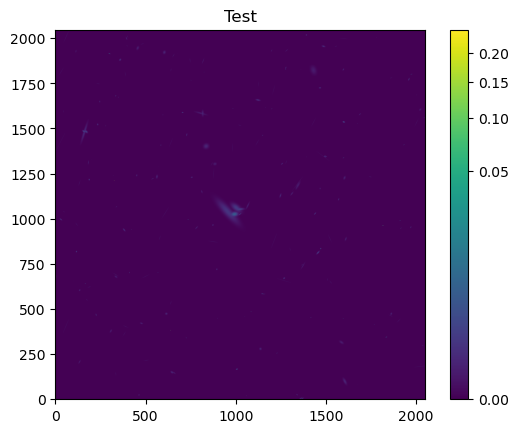

In [15]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.colors as mcolors

from casacore.tables import table

tbl = table(model_name)

data=tbl.getcol("map")

data = data[0,0,0,:,:]
# print(type(data), data.shape)

tbl.close()

im = plt.imshow(data, origin='lower', cmap='viridis', norm=mcolors.PowerNorm(0.3))
plt.title("Test")
plt.colorbar(im)

## Simulate the Model

In [28]:
from taitale.askap import csimulator
import os

os.system(f"rm -rf {ms_filename}")

csimulator(
    env=env,
    parset="./parsets/csimulator.in",
    args={
        "dataset": ms_filename,
        "sources.names": f"[{source_name}]",
        f"sources.{source_name}.direction": direction,
        f"sources.{source_name}.model": model_name,
        "spws.names": "[TestBand]",
        "spws.TestBand": f'[48, {frequency}, 1.0MHz, "XX YY XY YX"]',
        "observe.number": 1,
        "observe.scan0": f"[{source_name}, TestBand, -2h, 2h]",
    },
)

Starting csimulator


Debug: registered context Global=0


csimulator complete


In [60]:
from taitale.askap import mslist

mslist(env=env, args=f"--full {ms_filename}", logfile="mslist.txt")


Starting mslist
mslist complete


In [61]:
!cat mslist.txt

Debug: registered context Global=0
2025-02-14 07:49:49	INFO		   Observer: ASKAP simulator     Project:   
2025-02-14 07:49:49	INFO	+	Observation: ASKAP36(36 antennas)
2025-02-14 07:49:49	INFO	MSMetaData::_computeScanAndSubScanProperties 	Computing scan and subscan properties...
2025-02-14 07:49:49	INFO		Data records: 60480       Total elapsed time = 14400 seconds
2025-02-14 07:49:49	INFO	+	   Observed from   06-Mar-2007/11:32:53.9   to   06-Mar-2007/15:32:53.9 (UTC)
2025-02-14 07:49:49	INFO		
2025-02-14 07:49:49	INFO		Fields: 1
2025-02-14 07:49:49	INFO	+	  ID   Code Name                            RA               Decl           Epoch        nRows
2025-02-14 07:49:49	INFO	+	  0         J08161181-7039447               08:16:11.812800 -70.39.44.71200 J2000        60480
2025-02-14 07:49:49	INFO		Spectral Windows:  (1 unique spectral windows and 1 unique polarization setups)
2025-02-14 07:49:49	INFO	+	  SpwID  Name     #Chans   Frame   Ch0(MHz)  ChanWid(kHz)  TotBW(kHz) CtrFreq(MHz)  Corrs

## Imaging the simulation for verification

In [36]:
from taitale.askap import imager

image_name = f"image.i.{source_ms}"
imaging_workers = 1
nchanpercore = nchan // imaging_workers

print(f"channels: {nchan}")
print(f"nchanpercore: {nchanpercore}")
print(f"mpi_workers: {imaging_workers}")

# Default parset for Clean used
imager(
    env=env,
    workers=imaging_workers+1,
    parset="./parsets/cimager.in",
    args={
        "dataset": f"./{ms_filename}",
        "Images.Names": image_name,
        f"Images.{image_name}.direction": direction,
        f"Images.{image_name}.nchan": 1,
        f"Images.{image_name}.nterms": 2,
        "Images.shape": "[512, 512]",
        "Images.cellsize": "['2.5arcsec', '2.5arcsec']",
        "nchanpercore": nchanpercore,
        "restore": True,
    }
)

channels: 48
nchanpercore: 48
mpi_workers: 1
Starting imager


Debug: registered context Global=0
Debug: registered context Global=0


imager complete


### Viewing our results

Filename: image.i.08161181-7039447.taylor.0.restored.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      64   (512, 512, 1, 1)   float32   
None
Filename: weights.i.08161181-7039447.taylor.0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      60   (512, 512, 1, 1)   float32   
None


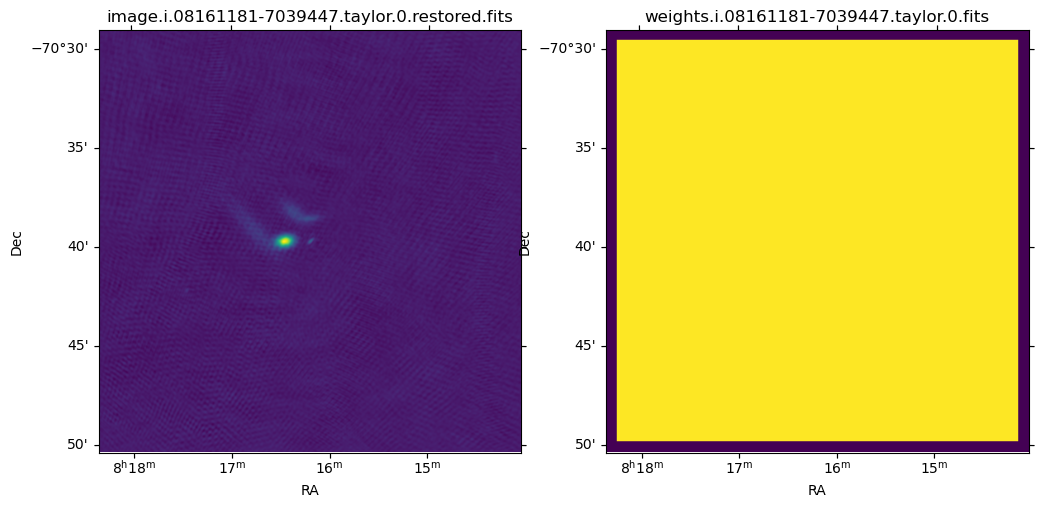

In [53]:
# Let's have a look at our image

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from astropy.io import fits
from astropy.wcs import WCS

%matplotlib inline

files = [
    f'image.i.{source_ms}.taylor.0.restored.fits',
    f'weights.i.{source_ms}.taylor.0.fits',
]

# Using one of the files to setup WCS projection
hdu = fits.open(files[0])[0]

wcs = WCS(hdu.header, naxis=2)
fig, ax = plt.subplots(1, 2, figsize=(12, 12), subplot_kw=dict(projection=wcs))

for idx in range(2):
    file = files[idx]
    print(fits.info(file))
    hdu = fits.open(file)[0]

    if idx==0:
        im = ax[idx].imshow(hdu.data[0,0,:,:], origin='lower', cmap='viridis', norm=mcolors.PowerNorm(0.3))
    else:
        im = ax[idx].imshow(hdu.data[0,0,:,:], origin='lower', cmap='viridis')
    ax[idx].set_xlabel('RA')
    ax[idx].set_ylabel('Dec')
    ax[idx].set_autoscale_on(False)
    ax[idx].set_title(files[idx])
    # plt.colorbar(im, ax=ax[idx])

plt.show()
